# Text Classification with BERT

Transformers have profoundly impacted Natural Language Processing (NLP) tasks by introducing a groundbreaking architecture that excels in comprehensively capturing contextual information. Their unique self-attention mechanisms enable a holistic analysis of input sequences, overcoming the constraints of conventional sequential models. This transformative breakthrough has resulted in notable progress in machine translation, sentiment analysis, and language comprehension. Exemplified by models like BERT and GPT, the Transformer architecture stands as a fundamental cornerstone in NLP, fostering innovation and pushing the frontiers of language understanding across a spectrum of applications and industries.

BERT, or Bidirectional Encoder Representations from Transformers, has emerged as a pivotal milestone in Natural Language Processing (NLP). Introduced by Google, BERT revolutionizes language understanding by considering context from both preceding and succeeding words in a sentence. This bidirectional approach enables BERT to grasp intricate nuances and dependencies, leading to superior performance in various NLP tasks. Its pre-training on vast amounts of text data equips it with a deep understanding of language structures, making BERT a transformative force in enhancing accuracy and contextual relevance across diverse applications.

<div class="alert alert-info">
    <h4>In this Project</h4>
    <ul>
        <li>Classification of Tweets into 6 different forms of Cyberbullying</li>
        <li>Using BERT base model and fine tuning it to our dataset</li>
    </ul>
</div>

## Setting Up

In [1]:
import os
import random
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from typing import Union, List
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['font.size'] = 14

/home/mb05005/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
def load_data(dataFile:str) -> Union[List, List]:
    df = pd.read_csv(dataFile)
    texts = df['tweet_text'].tolist()
    labels = df['cyberbullying_type'].tolist()
    return texts, labels

In [3]:
dataFile = 'cyberbullying_tweets.csv'
texts, labels = load_data(dataFile)

In [4]:
len(texts), len(labels)

(47692, 47692)

In [5]:
labEncoder = LabelEncoder()
labEncoder.fit(labels)
labelsEncoded = labEncoder.transform(labels)

## Exploratory Data Analysis

In [6]:
df = pd.DataFrame({'text':texts, 'labels':labels})
df.head()

,text,labels
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


### Check Missing Values

In [7]:
any(df.isna().sum())

False

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    47692 non-null  object
 1   labels  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


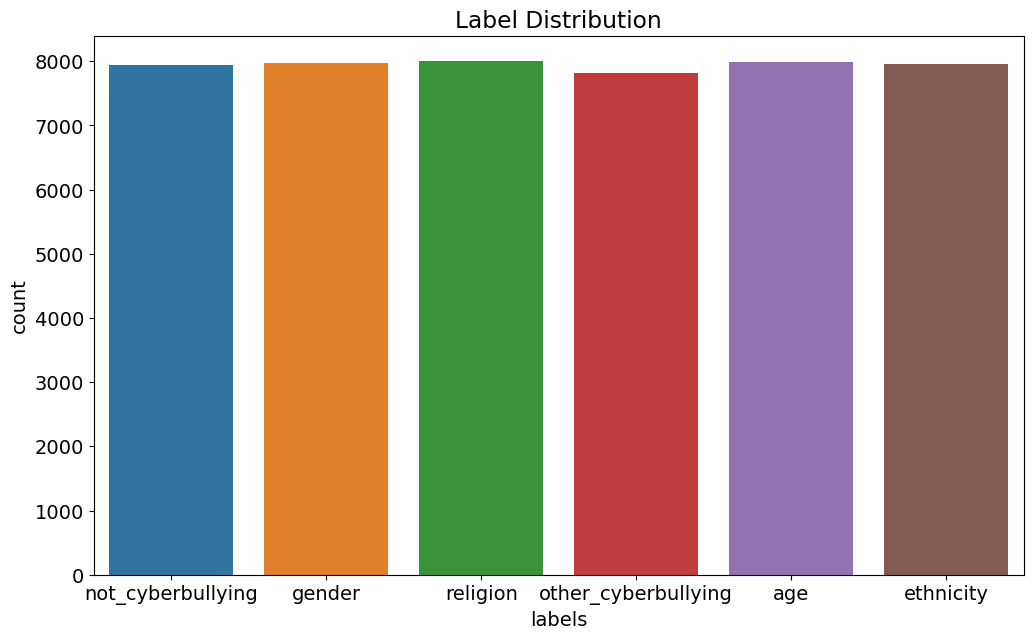

In [9]:
plt.figure(figsize=(12, 7))
sns.countplot(data=df, x='labels')
plt.title("Label Distribution")
plt.show()

### Tweet Length

In [10]:
df['length'] = df['text'].str.len()

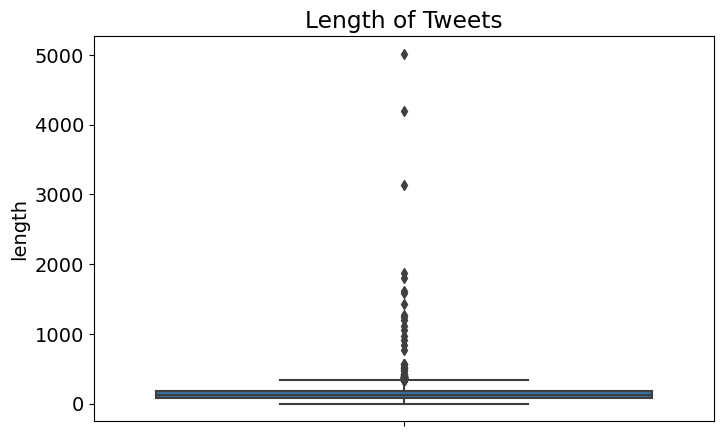

In [11]:
sns.boxplot(data=df, y='length')
plt.title("Length of Tweets")
plt.show()

### Word Count

In [12]:
def word_count(x):
    return len(x.split())

df['word_count'] = df['text'].apply(word_count)

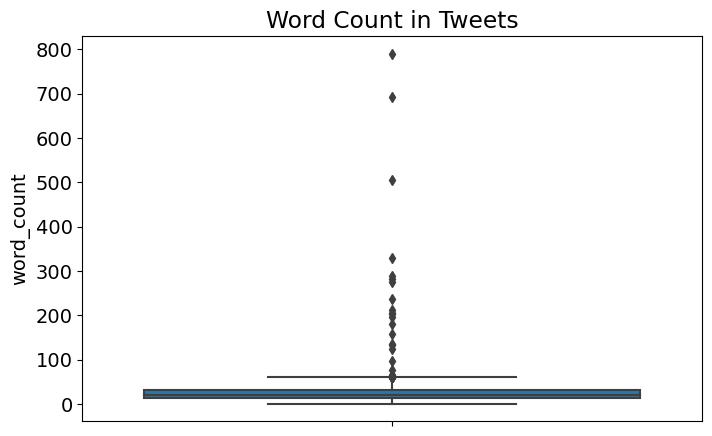

In [13]:
sns.boxplot(data=df, y='word_count')
plt.title("Word Count in Tweets")
plt.show()

## Dataset Building

In [14]:
class TextClassificationDataset(Dataset):

    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label)
        }

## Model Building

<img src="https://miro.medium.com/v2/resize:fit:640/format:webp/0*ViwaI3Vvbnd-CJSQ.png" />

<h4><strong>Architecture of BERT</strong></h4>
<p>
BERT makes use of Transformer, an attention mechanism that learns contextual relations between words (or sub-words) in a text. In its vanilla form, Transformer includes two separate mechanisms — an encoder that reads the text input and a decoder that produces a prediction for the task. Since BERT’s goal is to generate a language model, only the encoder mechanism is necessary.

As opposed to directional models, which read the text input sequentially (left-to-right or right-to-left), the Transformer encoder reads the entire sequence of words at once. Therefore it is considered bidirectional, though it would be more accurate to say that it’s non-directional. This characteristic allows the model to learn the context of a word based on all of its surroundings (left and right of the word).
</p>

In [15]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

## Utility Functions

In [16]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

In [17]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = list()
    actual = list()
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual.extend(labels.cpu().tolist())
    return accuracy_score(y_true=actual, y_pred=predictions), classification_report(y_true=actual, y_pred=predictions)

In [18]:
def predict_class(text, model, tokenizer, device, classes, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)

    return classes[preds.item()]

## Define Model Parameters

In [19]:
bert_model_name = 'bert-base-uncased'
num_classes = 6
max_length = 128
batch_size = 32
num_epochs = 5
learning_rate = 2e-5

## Splitting Dataset

In [20]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labelsEncoded, test_size=0.2, random_state=42)
len(train_texts), len(val_texts), len(train_labels), len(val_labels)

(38153, 9539, 38153, 9539)

In [21]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer=tokenizer, max_length=max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer=tokenizer, max_length=max_length)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

## Setting up the Model

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

In [23]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

## Model Training

In [24]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train(model, train_dataloader, optimizer, scheduler, device)
    accuracy, report = evaluate(model, val_dataloader, device)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(report)

Epoch 1/5
Validation Accuracy: 0.8537
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1603
           1       0.98      0.97      0.98      1603
           2       0.90      0.87      0.88      1531
           3       0.64      0.64      0.64      1624
           4       0.69      0.70      0.69      1612
           5       0.94      0.98      0.96      1566

    accuracy                           0.85      9539
   macro avg       0.86      0.85      0.85      9539
weighted avg       0.85      0.85      0.85      9539

Epoch 2/5
Validation Accuracy: 0.8642
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1603
           1       0.99      0.98      0.98      1603
           2       0.86      0.91      0.88      1531
           3       0.76      0.53      0.63      1624
           4       0.68      0.81      0.74      1612
           5       0.91      0.98      0.95      1566

 

In [25]:
# Assuming `model` is your PyTorch model
torch.save(model.state_dict(), "model.pth")

## Model Evaluation

In [26]:
classes = labEncoder.classes_.tolist()

In [27]:
for _ in range(10):
    random_idx = random.randint(0, len(val_texts))
    text = val_texts[random_idx]
    label = classes[val_labels[random_idx]]
    pred = predict_class(text, model, tokenizer, device, classes)

    print("=============================================")
    print(f"Text:\n{text}")
    print(f"Actual: {label}\tPredicted: {pred}")
    print("=============================================")

Text:
So we can't joke/comment about; suicide, death, robbery, pets, rape, being gay, being straight, religion, fat people, gingers, etc.,. Black humour is what helps people get through shit. Taking offence at every little comment is ridiculous and yes I have lost family to suicide.
Actual: gender	Predicted: gender
Text:
@smileyt22 @CSPANJNKY @Communist_Dog @RockDots @cspanwj Privateers taking over our public schools our most important asset
Actual: not_cyberbullying	Predicted: age
Text:
@Jeff_Nacht it's not pink.
Actual: other_cyberbullying	Predicted: not_cyberbullying
Text:
That’s what this is about, isn’t it? Were you bullied by other girls at school? This isn’t high school.
Actual: age	Predicted: age
Text:
@98Halima @johnnygjokaj @BilalIGhumman @cdnKhadija @rfrankh53 Snooor.
Actual: not_cyberbullying	Predicted: not_cyberbullying
Text:
Rape jokes aren't funny. They're inappropriate and offensive. So is using the word "gay" and "retarded" in negative connotation. #annoyed
Actual: gen

<div class="alert alert-success">
<h4>Conclusion</h4>
    <p>
    In conclusion, BERT is a powerful advancement in the field of NLP. With minimal preprocessing, setup and time, the model achieves great results,
    and is able to perform well across multiple classes. This is a rather basic usage of the architecture, it's capabalities extend to several other use cases
    and applications. There are several other models like BERT, based on the Transformer architecture that create a powerful ecosystem of these models.
    </p>
</div>

In [30]:
br_data = pd.read_csv('brandwatch_data.csv',usecols=['Title', 'Sentiment', 'Emotion', 'Region', 'Gender', 'Impressions'])

In [31]:
br_data.head()

,Title,Sentiment,Emotion,Region,Gender,Impressions
0,@realest_lauren @KellyScaletta Close our borde...,negative,Anger,Florida,male,358
1,@wow36932525 Didn't Michael Herrera talk about...,negative,NaN,Oregon,unknown,280
2,@KatiePhang FOR ALL OF YOU ILLITERATE DUMMIES ...,negative,Joy,Texas,unknown,5
3,@vickiringer The border patrol couldn’t legall...,negative,Sadness,California,male,75
4,@tuszyb Another dumbed down individual. THIS H...,negative,NaN,Texas,unknown,5


In [39]:
texts = br_data['Title'].tolist()
len(texts)

74630

In [46]:
from tqdm import tqdm  # For progress tracking

# Define the batch size
# batch_size = 32  # Adjust based on available memory and system capacity

# Function to predict class for a batch
def predict_class(text, model, tokenizer, device, classes, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)

    return classes[preds.item()]

# Prepare for batch processing
texts = br_data['Title'].tolist()  # Convert the 'Title' column to a list
predictions = []  # To store all predictions
model.to(device)  # Move model to the specified device (e.g., 'cuda' or 'cpu')

# Process in batches
for i in tqdm(range(0, len(texts))):
    pred = predict_class(texts[i], model, tokenizer, device, classes)
    predictions.append(pred)  # Append predictions for the batch

# Add predictions to the DataFrame
br_data['Prediction'] = predictions

# Display a sample of the updated DataFrame
br_data.head()

100%|█████████████████████████████████████| 74630/74630 [12:50<00:00, 96.82it/s]


,Title,Sentiment,Emotion,Region,Gender,Impressions,Prediction
0,@realest_lauren @KellyScaletta Close our borde...,negative,Anger,Florida,male,358,ethnicity
1,@wow36932525 Didn't Michael Herrera talk about...,negative,NaN,Oregon,unknown,280,ethnicity
2,@KatiePhang FOR ALL OF YOU ILLITERATE DUMMIES ...,negative,Joy,Texas,unknown,5,ethnicity
3,@vickiringer The border patrol couldn’t legall...,negative,Sadness,California,male,75,not_cyberbullying
4,@tuszyb Another dumbed down individual. THIS H...,negative,NaN,Texas,unknown,5,ethnicity


In [47]:
br_data.to_csv("bert_brandwatch.csv", index=False)